In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import BayesianGaussianMixture

import torch
from torch import nn
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from pdb import set_trace

In [2]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 12.1


### Variables and Hyperparameters

In [3]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = 'Oct22_protANDmRNA_weights_residual' # change run_name before running

# Paths
dataset_folder_path = '/home/ec2-user/ProteinLocalization/Datasets/' # dataset folder with all the proteome and mRNA data
summary_folder_path = '/home/ec2-user/ProteinLocalization/Summary/' # summary folder path to store summary reports
model_folder_path = '/home/ec2-user/ProteinLocalization/Model exports/' # model folder path to store models
figure_folder_path = '/home/ec2-user/ProteinLocalization/Figure exports/' # figure folder path to store figures
performance_folder_path = '/home/ec2-user/ProteinLocalization/Performance DF exports/' # performance folder path to store performance dataframes

testset_directory = dataset_folder_path+'Test set raw data/'
johansson_protein_path = testset_directory+'jo_protein_log2.csv'
johansson_mRNA_path = testset_directory+'jo_mrna_dropna.csv'
mertins_protein_path = testset_directory+'me_protein_dropna.csv'
mertins_mRNA_path = testset_directory+'me_rna_dropna.csv'



# Define the Model
Model = 'CustomNN-stride2' # 'ResNet18', 'CustomNN-reg', and 'CustomNN-stride2' are the options

# Define loss function
LossFunc_Name = 'CrossEntropy' # 'CrossEntropy', 'Focal' are the options

# Dataset
Set = 'Protein + mRNA' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.2

# Standard deviation for add-noise transformation
StandardDeviation = 0.05

# Learning rate scheduler
LrScheduler = True
Learner_rate = 5e-5

# Synthetic data
Bayesian = True
Normal = False

# Training set imbalance sampling method, can only choose one
ImbalanceSampler = True

# Optimizer
Weight_Decay = 0.001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

Momentum = 0.9
#  specific for SGD optimizer, not applicable when using Adam optimizer
#  a way to smooth noise that is passed to the optimizer, 0.9
#  momentum is deterimental without label smoothing

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.05
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Transformation
TransformOrNot = True

# Class weight to loss function
ApplyClassWeightToLoss = True
#  makes the loss weights equal to the fraction of each category label
#  note, a layer is added to the model so the outputs of the model are equal to the number of categories

# Batch size
batch = 64

# Epoch amount
epochs = 200

# Warning
if Bayesian == Normal:
    raise ValueError('Can only choose one synthetic data method')

### Protein, mRNA dataframe, localization label set up

In [5]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'kr_pro_raw.csv' # proteomics file path, normalized by pool, log2 transformed.
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Gene']
PD = PD.loc[:,PD.columns!='Gene']
PD.dropna(inplace=True)

# Specific for krug raw ddamsproteomics, these 3 tumors are not in transcriptome data
PD = PD.loc[:,PD.columns!='X11BR057']
PD = PD.loc[:,PD.columns!='X11BR076']
PD = PD.loc[:,PD.columns!='X11BR078']

# Nate changes
# undo log2 transform
PD = PD**2
# row normalize
for index in PD.index:
    PD.loc[index,:] = PD.loc[index,:]/np.average(PD.loc[index,:])
# column normalize
for column in PD.columns:
    PD.loc[:,column] = PD.loc[:,column]/np.median(PD.loc[:,column])
# Replace zero values with a small positive number
PD = PD.replace(0, 2**(-10))
# log transform
PD = np.log2(PD)

# Put values of each column in the DataFrame into a list
values = np.sort(PD.values.flatten().tolist())

#Find the 2.5 and 97.5 percentile
percentile_high = np.percentile(values, 97.5)
percentile_low = np.percentile(values, 2.5)

# Use the percentile for normalization
#   the normalization factor is computed as the 2.5th to 97.5th percentile of all data points in the matrix
#   This does not force the distributions for each gene to be the same because the same normalization factor is used for all genes
#     Not a normalization factor based on the distribution of each gene
#PD = (PD - percentile_low) / (percentile_high - percentile_low)
PD = (PD) / (percentile_high - percentile_low)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'kr_rna_raw.csv' # mRNA file path, gene centric median normalized, log2 transformed
MD = pd.read_csv(dataset_folder_path + MFP)


# Data set wrangling
MD.index = MD.loc[:,'Gene']
MD = MD.loc[:,MD.columns!='Gene']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

# undo log2 transform
MD = MD**2

# row normalize
for index in MD.index:
    MD.loc[index,:] = MD.loc[index,:]/np.average(MD.loc[index,:])

# column normalize
for column in MD.columns:
    MD.loc[:,column] = MD.loc[:,column]/np.median(MD.loc[:,column])

# Replace zero values with a small positive number
MD = MD.replace(0, 2**(-10))

# log transform
MD = np.log2(MD)

# Put values of each column in the DataFrame into a list
values = np.sort(MD.values.flatten().tolist())

# Find the 2.5 and 97.5 percentile
percentile_high = np.percentile(values, 97.5)
percentile_low = np.percentile(values, 2.5)

# Use the percentile for normalization
#MD = (MD - percentile_low) / (percentile_high - percentile_low)
MD = (MD) / (percentile_high - percentile_low)

# Open the labels data
LFP = 'SubCellBarcode.MCF7.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in PD.index if ((value in MD.index) & (value in LD.index))]
PD = PD.loc[IntersectingGenes,:]
MD = MD.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Number of genes in Krug dataset')
print(len(PD.index))
print(len(MD.index))
print(len(LD.index))

# Krug dataset label distribution
count = LD['Localization'].value_counts()

# Print out the label distribution
print('Krug proteome label distribution:')
print(count)

Number of genes in Krug dataset
4839
4839
4839
Krug proteome label distribution:
Localization
Cytosol         2121
Nuclear         1392
Secretory        991
Mitochondria     335
Name: count, dtype: int64


### Set seed function

In [6]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Synthetic data using Baysian GGM or norm dist

In [7]:
# Set seed to ensure reproducibility
set_seed(Seed)

if Bayesian:

    if Set == 'Protein' or Set == 'Protein + mRNA':
        # Fit the dataset to Bayesian Gaussian Mixture Model
        PD_bgm = BayesianGaussianMixture(n_components=5, random_state=42) # Assuming the maximum number of clusters in dataset is 5
        PD_T = PD.T
        PD_bgm.fit(PD_T)
    
        # Generate X new synthetic tumors, result is an array
        if Set == 'Protein':
            synthetic_PD, _ = PD_bgm.sample(int(Canvas_Size*Canvas_Size-PD.columns.size))
        elif Set == 'Protein + mRNA':
            synthetic_PD, _ = PD_bgm.sample(int((Canvas_Size*Canvas_Size-PD.columns.size*2)/2))
    
        # Transpose back before merging
        synthetic_PD = synthetic_PD.T

        # Convert the result to a DataFrame
        synthetic_PD = pd.DataFrame(synthetic_PD.tolist(), index=PD.index)

        # Merge the synthetic data with the original data
        PD = pd.concat([PD, synthetic_PD], axis=1)

        # Sanity check for the number of tumors in each dataframe
        
        if Set == 'Protein + mRNA':
            assert len(PD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(PD.columns) == Canvas_Size*Canvas_Size

        print(f'{Set} - Bayesian PD: {len(PD.columns)}')
      
    if Set == 'mRNA' or Set == 'Protein + mRNA':
        # Fit the dataset to Bayesian Gaussian Mixture Model
        MD_bgm = BayesianGaussianMixture(n_components=5, random_state=43) # Assuming the maximum number of clusters in dataset is 5
        MD_T = MD.T
        MD_bgm.fit(MD_T)

        # Generate X new synthetic tumors, result is an array
        if Set == 'mRNA':
            synthetic_MD, _ = MD_bgm.sample(int(Canvas_Size*Canvas_Size-MD.columns.size))
        elif Set == 'Protein + mRNA':
            synthetic_MD, _ = MD_bgm.sample(int((Canvas_Size*Canvas_Size-MD.columns.size*2)/2))

        # Transpose back before merging
        synthetic_MD = synthetic_MD.T

        # Convert the result to a DataFrame
        synthetic_MD = pd.DataFrame(synthetic_MD.tolist(), index=MD.index)

        # Merge the synthetic data with the original data
        MD = pd.concat([MD, synthetic_MD], axis=1)
         
        # Sanity check for the number of tumors in each dataframe
        if Set == 'Protein + mRNA':
            assert len(MD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(MD.columns) == Canvas_Size*Canvas_Size
        print(f'{Set} - Bayesian MD: {len(MD.columns)}')

elif Normal: # use normal distritbuion
    
    # Helper function
    def SyntheticNormDistAbund(row, std_dev):
        return [np.random.normal(loc=abund, scale=std_dev) for abund in row]

    if Set == 'Protein' or Set == 'Protein + mRNA':
        # Calculate the standard deviation of each row in PD and MD
        PD_gene_std = PD.std(axis=1)
    
        # Randomly subset X tumors from PD, apply the same subset tumors to MD
        if Set == 'Protein':
            subset_columns = np.random.choice(PD.columns, int(Canvas_Size*Canvas_Size-PD.columns.size), replace=False)
            
        if Set == 'Protein + mRNA':
            subset_columns = np.random.choice(PD.columns, int((Canvas_Size*Canvas_Size-PD.columns.size*2)/2), replace=False)
        
        subset_PD = PD[subset_columns]
        # Generate X numbers for each gene using normal distribution 
        # mean = individual tumors' abundance
        # std = std of total tumors' abunbdance

        # Applying the function to each row in subset PD and MD
        synthetic_PD = subset_PD.apply(lambda row: SyntheticNormDistAbund(row, PD_gene_std[row.name]), axis=1)

        # Convert the result to a DataFrame
        synthetic_PD = pd.DataFrame(synthetic_PD.tolist(), index=PD.index)

        # Merge the synthetic data with the original data
        PD = pd.concat([PD, synthetic_PD], axis=1)

        # Sanity check for the number of tumors in each dataframe
        if Set == 'Protein + mRNA':
            assert len(PD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(PD.columns) == Canvas_Size*Canvas_Size
        print(f"{Set} - Normal PD: {len(PD.columns)}")

    if Set == 'mRNA' or Set == 'Protein + mRNA':
        # Calculate the standard deviation of each row in PD and MD
        MD_gene_std = MD.std(axis=1)

        # Randomly subset X tumors from MD
        if Set == 'mRNA':
            subset_columns = np.random.choice(MD.columns, int(Canvas_Size*Canvas_Size-MD.columns.size), replace=False)
            subset_MD = MD[subset_columns]
        elif Set == 'Protein + mRNA':
            subset_MD = MD[subset_columns]
        
        # Generate X numbers for each gene using normal distribution 
        # mean = individual tumors' abundance
        # std = std of total tumors' abunbdance

        # Applying the function to each row in subset PD and MD
        synthetic_MD = subset_MD.apply(lambda row: SyntheticNormDistAbund(row, MD_gene_std[row.name]), axis=1)

        # Convert the result to a DataFrame
        synthetic_MD = pd.DataFrame(synthetic_MD.tolist(), index=MD.index)

        # Merge the synthetic data with the original data
        MD = pd.concat([MD, synthetic_MD], axis=1)
        
        # Sanity check for the number of tumors in each dataframe
        if Set == 'Protein + mRNA':
            assert len(MD.columns) == Canvas_Size*Canvas_Size // 2
        else:
            assert len(MD.columns) == Canvas_Size*Canvas_Size

        print(f"{Set} - Normal MD: {len(MD.columns)}")
    
else:
    print('No synthetic data generated')

Protein + mRNA - Bayesian PD: 162
Protein + mRNA - Bayesian MD: 162


### Canvas and RGB tensor generation functions

In [8]:
def interleave_arrays(set=None, PD=None, MD=None):
    """
    Interleave the values from PD, MD and RD arrays if using both datasets and feature engineering, otherwise sort the PD or MD array.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    PD (pd.DataFrame): Array containing normalized protein abundance data.
    MD (pd.DataFrame): Array containing normalized mRNA abundance data.
    
    Returns:
    np.array: Interleaved array of PD and MD values if both are provided, otherwise sorted PD or MD array.
    """
    def sort_and_interleave(PD, MD=None):
        sum_abundance = PD + (MD if MD is not None else 0)
        sorted_indices = np.argsort(sum_abundance)[::-1]
        PD_sorted = np.take_along_axis(PD.values, sorted_indices, axis=1)
        if MD is not None:
            MD_sorted = np.take_along_axis(MD.values, sorted_indices, axis=1)
            return PD_sorted, MD_sorted
        return PD_sorted, None

    if set == 'Protein + mRNA':
        assert PD.shape == MD.shape, "PD and MD dataframes must have the same shape."
        PD_sorted, MD_sorted = sort_and_interleave(PD, MD)
        
        interleaved_array = np.empty((len(PD_sorted), Canvas_Size*Canvas_Size), dtype=PD_sorted.dtype)
        interleaved_array[:, 0::2] = PD_sorted
        interleaved_array[:, 1::2] = MD_sorted

        return interleaved_array

    elif set == 'Protein':
        assert PD is not None and MD is None, "PD dataframe must be provided."
        PD_sorted, _ = sort_and_interleave(PD)
        return PD_sorted

    elif set == 'mRNA':
        assert MD is not None and PD is None, "MD dataframe must be provided."
        MD_sorted, _ = sort_and_interleave(MD)
        return MD_sorted
    
    else:
        raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")

def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, PD, MD):
    """
    Create RGB tensors from PD and MD data using the specified pattern.
    
    Parameters:
    PD (pd.DataFrame): DataFrame containing normalized protein abundance data.
    MD (pd.DataFrame): DataFrame containing normalized mRNA abundance data.
    pattern (str): Pattern to use for arranging the data ('spiral').
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    # PD is a row of the protein abundance dataframe
    # MD is a row of the protein abundance dataframe

    final_array = interleave_arrays(set, PD, MD)
    final_array = final_array.flatten()
    num_pixels = len(final_array)

    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.uint8)
    for i, (x, y) in enumerate(coords):
        if i < len(final_array):
            value = final_array[i]
            fraction_of_color_range = (value-(-1))/2
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            if value > 1:
                #rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
                rgb_tensor[x, y] = [255, 0, 0]  # Blue for value < 0
            elif value < -1:
                rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            elif value == 0:
                rgb_tensor[x, y] = [0, 0, 0]
            else:
                rgb_tensor[x, y] = [255 * fraction_of_color_range, 0, 255 * (1 - fraction_of_color_range)]
                
    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

def annotate_canvas(set, PD, MD, rgb_tensor, gene_name, label, numbering=True, label_type='order'):
    """
    Plot the canvas with RGB tensor and optionally number the pixels.

    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    PD (pd.DataFrame): DataFrame containing normalized protein abundance data.
    MD (pd.DataFrame): DataFrame containing normalized mRNA abundance data.
    rgb_tensor (torch.Tensor): The RGB tensor.
    gene_name (str): The gene name.
    label (int): The label.
    numbering (bool): Whether to number the pixels. Default is True.
    label_type (str): Type of labeling for the pixels. Options are 'order', 'abundance', 'index', 'none'.
                      Default is 'order'.
    """
    canvas = rgb_tensor.numpy().transpose(1, 2, 0)  # Convert to HWC format for plotting

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(canvas)

    if numbering:
        num_pixels = canvas.shape[0] * canvas.shape[1]
        coords = gen_horizontal_coords(canvas.shape[0], num_pixels)

        if label_type in ['abundance', 'index']:
            final_array = interleave_arrays(set, PD, MD)
            np.set_printoptions(suppress=True) # Suppress scientific notation and set decimal precision
            final_array = final_array.flatten()
            sum_product = PD + (MD if MD is not None else 0)
            sorted_indices = np.argsort(sum_product, axis=1)
            sorted_indices = sorted_indices.flatten()

        for i, (x, y) in enumerate(coords):
            if label_type == 'order':
                label_text = str(i + 1)
            elif label_type == 'abundance':
                label_text = f'{final_array[i]:.2f}'
            elif label_type == 'index':
                original_index = sorted_indices[i // (2 if set == 'Protein + mRNA' else 1)]
                label_text = str(original_index)
            else:
                raise ValueError("label_type must be 'order', 'abundance', or 'index'")
            ax.text(y, x, label_text, ha='center', va='center', color='white', fontsize=6)
    
    title_map = {
        'order': "Pixel plotting order",
        'abundance': "Tumor Abundances of each pixel",
        'index': "Tumor Indices of each pixel",
        'none': ""
    }
    ax.set_title(f"Gene: {gene_name}, Label: {label.item()}, {title_map.get(label_type, '')}")
    
    plt.show()

### Transformation class

In [9]:
class NoiseTransform:
    """
    A class that applies normal noise transformation to a DataFrame.

    Args:
        mean (float): The mean of the normal distribution. Default is 0.
        std_dev (float): The standard deviation of the normal distribution. Default is 0.2.
    """

    def __init__(self, mean=0, std_dev=StandardDeviation):
        super(NoiseTransform, self).__init__()
        self.mean = mean
        self.std_dev = std_dev

    def forward(self, df):
        """
        Applies normal noise transformation to the input DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The transformed DataFrame with normal noise applied.
        """
        tensor = torch.from_numpy(df.values).float()
        noise = torch.empty(tensor.size()).normal_(self.mean, self.std_dev)
        noisy_tensor = tensor + noise
        
        # Convert the tensor back to DataFrame
        df_transformed = pd.DataFrame(noisy_tensor.numpy(), index=df.index, columns=df.columns)
        
        return df_transformed
    
class CombinedTransform:
    """
    A class representing a combined transformation.

    Args:
        set: The dataset used for the transformation.
        transform1: The first transformation to apply.
        transform2: The second transformation to apply (optional).
        FeatureEngineering: Whether to use the feature engineering data.

    Attributes:
        transform1: The first transformation.
        transform2: The second transformation.
        FeatureEngineering: Whether to use the feature engineering data.

    Methods:
        __call__: Applies the combined transformation to the input dataframes.

    """

    def __init__(self, set, transform1=None, transform2=None):
        self.set = set
        self.transform1 = transform1 if transform1 is not None else None
        self.transform2 = transform2 if transform2 is not None else None

    def __call__(self, set, df1, df2):
        """
        Applies the combined transformation to the input dataframes.

        Args:
            set: The dataset used for the transformation.
            df1: The first dataframe.
            df2: The second dataframe.

        Returns:
            transformed_rgb_tensors: The transformed RGB tensors.

        """

        # apply the first transformation (noise) to df1 and df2; df1 is PD, df2 is MD
        if self.transform1 is not None:
            df1 = self.transform1.forward(df1) if df1 is not None else None
            df2 = self.transform1.forward(df2) if df2 is not None else None
            
        # apply the second transformation (random column) to df1 and df2
        if self.transform2 is not None:
            df1, df2 = self.transform2.forward(df1, df2) if df1 is not None and df2 is not None else (None, None)
        
        # if we are using feature engineering, derive third dataframe from already noise and/or column random transformed 
        if self.set == 'Protein':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, None)
        elif self.set == 'mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, None, df2)
        elif self.set == 'Protein + mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, df2)
        
        if transformed_rgb_tensors is None:
            raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")
                
        return transformed_rgb_tensors

### Dataset class

In [10]:
class MyDataset(Dataset):
    def __init__(self, set, PD, MD, labels, gene_names, transform=None):
        self.set = set
        self.PD = PD if PD is not None else None
        self.MD = MD if MD is not None else None
        self.labels = labels
        self.gene_names = gene_names
        self.transform = transform

    def __getitem__(self, idx):
        pd_data = self.PD.iloc[idx].to_frame().T if self.PD is not None else None
        md_data = self.MD.iloc[idx].to_frame().T if self.MD is not None else None
        label = self.labels[idx]
        gene_name = self.gene_names[idx]

        if self.transform:  
            if self.set == 'Protein + mRNA':
                tensor = self.transform(self.set, pd_data, md_data)
            elif self.set == 'Protein':
                tensor = self.transform(self.set, pd_data, None)
            elif self.set == 'mRNA':
                tensor = self.transform(self.set, None, md_data)

        else:
            if self.set == 'Protein + mRNA':
                tensor = create_rgb_tensors(self.set, pd_data, md_data)
            elif self.set == 'Protein':
                tensor = create_rgb_tensors(self.set, pd_data, None)
            elif self.set == 'mRNA':
                tensor = create_rgb_tensors(self.set, None, md_data)

        # Ensure tensor is not None
        if tensor is None:
            raise ValueError("Both PD and MD are None, cannot create tensor.")

        return tensor, label, gene_name

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

## Model training

### Dataloaders

In [11]:
# Create an instance of the transform
noise_transform = NoiseTransform()

# Create an instance of the combined transform， change here if doing different transformation
# Transform 1 default is noise_transform, transform 2 default is TBD
transform = CombinedTransform(set=Set, transform1=noise_transform, transform2=None)


# Set seed to ensure reproducibility
set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label dataframe
labels = encoder.fit_transform(LD.values.ravel())

# Convert the labels to tensors
labels = torch.tensor(labels)

# Split the data into training and validation sets using the labels indices, random state is set
indices = range(len(labels))
train_indices, val_indices, train_labels, val_labels = train_test_split(indices, labels, test_size=Validation_Fraction, random_state=42)

# Use the indices to split PD and MD
if Set == 'Protein' or 'Protein + mRNA':
    train_PD = PD.iloc[train_indices]
    val_PD = PD.iloc[val_indices]
    print('Proteome data set is splited')

if Set == 'mRNA' or 'Protein + mRNA':
    train_MD = MD.iloc[train_indices]
    val_MD = MD.iloc[val_indices]
    print('mRNA data set is splited')

# Save gene names
train_gene_names = train_PD.index.tolist()
val_gene_names = val_PD.index.to_list()

## Create the datasets
# Initialize transform to None
transform_to_use = None

# Check if transformations should be applied
if TransformOrNot:
    transform_to_use = transform # transform is defined above

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    train_dataset = MyDataset(Set, train_PD, None, train_labels, train_gene_names, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, None, val_labels, val_gene_names, transform=None)
elif Set == 'mRNA':
    train_dataset = MyDataset(Set, None, train_MD, train_labels, train_gene_names, transform=transform_to_use)
    val_dataset = MyDataset(Set, None, val_MD, val_labels, val_gene_names, transform=None)
elif Set == 'Protein + mRNA':
    train_dataset = MyDataset(Set, train_PD, train_MD, train_labels, train_gene_names, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, val_MD, val_labels, val_gene_names, transform=None)
else:
    raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")

# Create the training data loaders, iteration of each index happens here
if ImbalanceSampler:
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, sampler=ImbalancedDatasetSampler(train_dataset))
    print('Train dataloader is balanced by ImbalancedDatasetSampler')
else:
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    print('Train dataloader is not balanced by ImbalancedDatasetSampler')

# Create the validation data loader, shuffling is not necessary
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
print('Validation dataloader is not shuffled')


# Check quantity of classes in data loaders
# Print out the labels corresponding to each class
for i, label in enumerate(encoder.classes_):
    print(f"{i} is {label}")

# Initialize a Counter object
train_class_counts = Counter()

# Iterate over the DataLoader
for _, labels, _ in train_dataloader:
    # Update the Counter with the labels in the current batch
    train_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Training set label counts: {sorted(train_class_counts.items())}")

# Initialize a Counter object
val_class_counts = Counter()

# Iterate over the DataLoader
for _, labels, _ in val_dataloader:
    # Update the Counter with the labels in the current batch
    val_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Validation set label counts: {sorted(val_class_counts.items())}")

Proteome data set is splited
mRNA data set is splited
Train dataloader is balanced by ImbalancedDatasetSampler
Validation dataloader is not shuffled
0 is Cytosol
1 is Mitochondria
2 is Nuclear
3 is Secretory
Training set label counts: [(0, 953), (1, 916), (2, 975), (3, 1027)]
Validation set label counts: [(0, 421), (1, 64), (2, 272), (3, 211)]


### Visualize the tensors in data loader

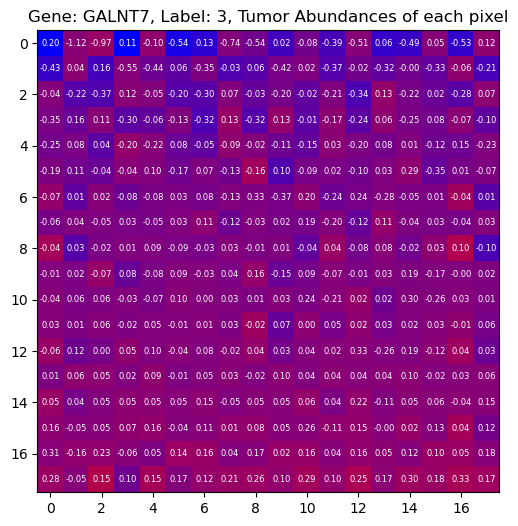

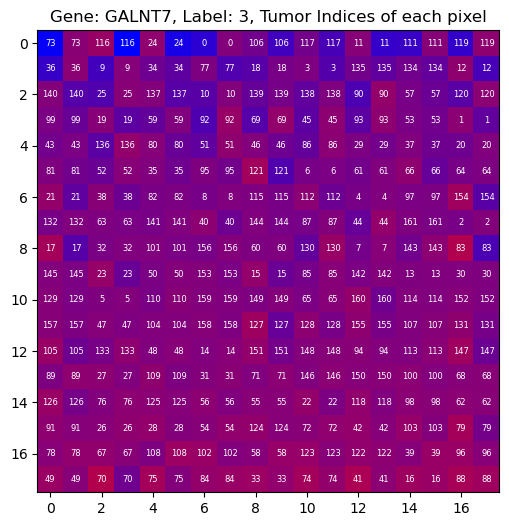

In [12]:
# Visualize the train data loader to see the transformed tensors
train_batch_images, train_batch_labels, train_batch_gene_names = next(iter(train_dataloader))

# Use first image in the batch
first_image_in_train_batch = train_batch_images[0]
image_to_plot = first_image_in_train_batch.permute(1, 2, 0).numpy().astype('uint8')
first_gene_in_train_batch = train_batch_gene_names[0]
first_label_in_train_batch = train_batch_labels[0]

if isinstance(train_PD.loc[first_gene_in_train_batch], pd.DataFrame) and isinstance(train_MD.loc[first_gene_in_train_batch], pd.DataFrame):
    # If it's a DataFrame, take the first row
    PD_to_plot = train_PD.loc[first_gene_in_train_batch][:1].T
    MD_to_plot = train_MD.loc[first_gene_in_train_batch][:1].T
else:
     # If it's a Series, convert to DataFrame with a single row if needed
    PD_to_plot = train_PD.loc[first_gene_in_train_batch].to_frame().T
    MD_to_plot = train_MD.loc[first_gene_in_train_batch].to_frame().T


# Visualize the tensor as an image using PlotCanvasWithNumbers
if Set == 'Protein + mRNA':
    annotate_canvas(Set, PD_to_plot, MD_to_plot, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, PD_to_plot, MD_to_plot, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='index')
elif Set == 'Protein':
    annotate_canvas(Set, PD_to_plot, None, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, PD_to_plot, None, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='index')

elif Set == 'mRNA':
    annotate_canvas(Set, None, MD_to_plot, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, None, MD_to_plot, first_image_in_train_batch, first_gene_in_train_batch, first_label_in_train_batch, numbering=True, label_type='index')

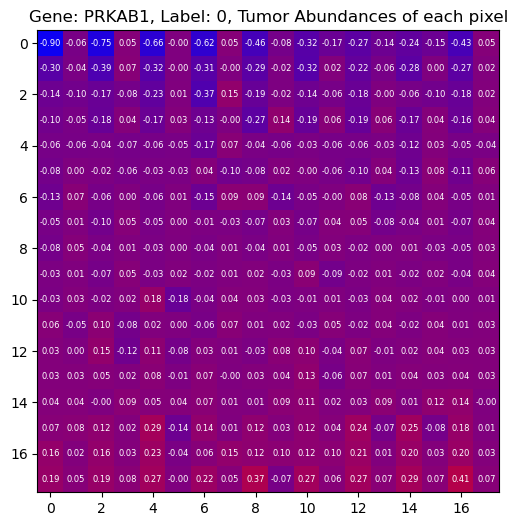

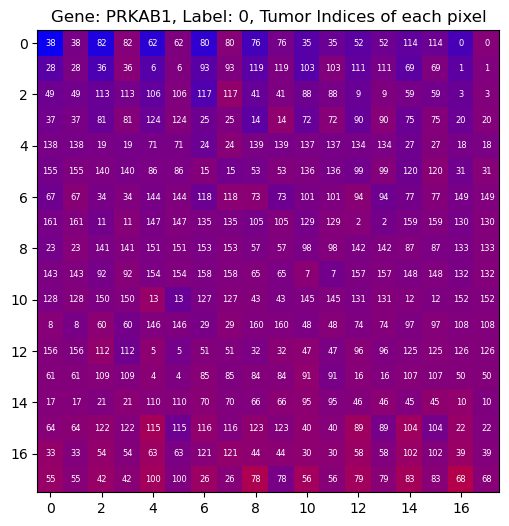

In [13]:
# Visualize the validation data loader to see the transformed tensors
val_batch_images, val_batch_labels, val_batch_gene_names = next(iter(val_dataloader))

# Use first image in the batch
first_image_in_val_batch = val_batch_images[0]
image_to_plot = first_image_in_val_batch.permute(1, 2, 0).numpy().astype('uint8')
first_gene_in_val_batch = val_batch_gene_names[0]
first_label_in_val_batch = val_batch_labels[0]

# Visualize the tensor as an image using PlotCanvasWithNumbers
if Set == 'Protein + mRNA':
    annotate_canvas(Set, val_PD.loc[first_gene_in_val_batch].to_frame().T, val_MD.loc[first_gene_in_val_batch].to_frame().T, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, val_PD.loc[first_gene_in_val_batch].to_frame().T, val_MD.loc[first_gene_in_val_batch].to_frame().T, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='index')
elif Set == 'Protein': 
    annotate_canvas(Set, val_PD.loc[first_gene_in_val_batch].to_frame().T, None, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, val_PD.loc[first_gene_in_val_batch].to_frame().T, None, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='index')
elif Set == 'mRNA':
    annotate_canvas(Set, None, val_MD.loc[first_gene_in_val_batch].to_frame().T, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='abundance')
    annotate_canvas(Set, None, val_MD.loc[first_gene_in_val_batch].to_frame().T, first_image_in_val_batch, first_gene_in_val_batch, first_label_in_val_batch, numbering=True, label_type='index')


### Sanity check

In [14]:
# For recording the time and double check the sets before running
print(Time_Stamp)
print(f'Dataset: {Set}')
print(f'Image size: {Canvas_Size} x {Canvas_Size}')
print(f'PD: {len(PD.columns) if PD is not None else None}, MD: {len(MD.columns) if MD is not None else None}')

2024_11191639
Dataset: Protein + mRNA
Image size: 18 x 18
PD: 162, MD: 162


### CustomNN class

In [15]:
# Model with initial stride of 2 - Nate's
class SimpleResNet2(nn.Module):
    def __init__(self):
        super(SimpleResNet2, self).__init__()

        # Dropout percentage for the model
        self.dropout_percentage = 0.5

        # Conv1: 2x2 kernel, stride 2 (input 18x18 -> output 9x9)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2), stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)

        # Conv2: 2x2 kernel, stride 1 (output 8x8)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        # Conv3: 2x2 kernel, stride 1 (output 7x7)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(2, 2), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(16)
        self.dropout3 = nn.Dropout(p=0.3)  # Dropout after conv3

        # Conv4: 2x2 kernel, stride 2 (output 6x6)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(2, 2), stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(8)
        self.dropout4 = nn.Dropout(p=0.3)  # Dropout after conv4

        # Fully connected layers
        self.fc = nn.Linear(in_features=6*6*8, out_features=128)
        self.fc_dropout = nn.Dropout(p=self.dropout_percentage)  # Dropout after fully connected layer
        self.out = nn.Linear(128, 4)

    # initialize with random weights
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))  # Output: 64 channels, 9x9

        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))  # Output: 128 channels, 8x8

        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))  # Output: 256 channels, 7x7
        # x = self.dropout3(x)

        # Fourth conv block with downsampling
        x = F.relu(self.bn4(self.conv4(x)))  # Output: 512 channels, 3x3
        # x = self.dropout4(x)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc(x))
        # x = self.fc_dropout(x)  # Dropout after fully connected layer
        x = self.out(x)

        return x

### Training and testing epoch loop functions

In [16]:
# Function for training the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0

    # Iterate over each "batch" stored in the DataLoader object (dataloader)
    # Unpack each batch into the tuple (X,y,_), where X is the array of images in the batch and y the array of labels. 
    #   "_" allows for anything else to be unpacked if it's present
    #   A batch in the DataLoader is a tuple
    for batch, (X, y, _) in enumerate(dataloader):

        # Prepare data
        X = X.to(torch.float32) # convert to float32 to avoid error stating byte expected but found float
        X = X.to(device)
        y = y.to(device)

        # Forward pass: predict classes
        # calling a nn.Module object with an input will lead to the forward() method being called
        # in our case the SimpleResNet2 object is a child of the nn.Module() object as specified in the SimpleResNet2 class definition
        # an array of predicted labels for each image in X is returned
        pred = model(X)
    
        # Compute the cross-entropy loss 
        # The loss is computed based on the array of predicted labels, their probabilities, and the actual labels
        loss = loss_fn(pred, y)

        # Compute the softmax probabilities
        softmax_probs = F.softmax(pred, dim=1)

        # Compute the entropy of the softmax output for the confidence penalty
        entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1)

        # Confidence penalty: encourage high entropy (i.e., reduce overconfidence)
        penalty = torch.mean(entropy)
        
        # Total loss: cross-entropy loss + confidence penalty (scaled by lambda); lambda set to 0.1
        total_loss_with_penalty = loss - 0.1 * penalty

        # Backpropagation
        optimizer.zero_grad() # zero the parameter gradients 
        total_loss_with_penalty.backward() # backpropagate the loss
        optimizer.step() # adjust parameters based on the calculated gradients

        total_loss += loss.item() # extract the loss value
        current_lr = optimizer.param_groups[0]['lr']

    if LrScheduler:
        exp_lr_scheduler.step()   
    else:
        pass

    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, current_lr
            
# Function for validating the model
def test_loop(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0, 0
    
    for X, y, _ in dataloader:
        
        # Prepare data
        X = X.to(torch.float32)
        X = X.to(device)
        y = y.to(device)

        # Forward pass: predict classes
        pred = model(X)
        
        # Compute the softmax probabilities
        softmax_probs = F.softmax(pred, dim=1)

        # Compute the loss
        test_loss += loss_fn(pred, y).item()

        # Calculate accuracy: choose the class with the highest probability
        accuracy += (softmax_probs.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    accuracy /= size
        
    return test_loss, accuracy

# Function for testing the model with confusion matrix, and softmax output with a condition of >50% certanty
def test_loop_with_confusion_matrix(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy, no_prediction_count = 0, 0, 0
    
    all_preds = []
    all_labels = []
    
    for X, y, _ in dataloader:
        # convert to float32 to avoid byte/float mismatch error
        X = X.to(torch.float32)
        X = X.to(device)
        pred = model(X)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(pred, dim=1)
        
        # Get the maximum probability and its corresponding class
        max_prob, predicted_class = torch.max(probabilities, dim=1)
        
        # Only consider predictions with a probability greater than 0.5
        accepted_probability = 0
        valid_predictions = max_prob > accepted_probability
        
        # Convert the labels to the same device and calculate the loss
        y = y.to(device)
        test_loss += loss_fn(pred, y).item()
        
        # Append valid predictions and corresponding labels to lists for confusion matrix
        all_preds.extend(predicted_class[valid_predictions].cpu().numpy())
        all_labels.extend(y[valid_predictions].cpu().numpy())
        
        # Count valid predictions where probability is greater than 0.5
        valid_preds_count = valid_predictions.sum().item()
        
        # Calculate accuracy only for valid predictions
        accuracy += (predicted_class[valid_predictions] == y[valid_predictions]).type(torch.float).sum().item()
        
        # Count how many predictions were skipped (i.e., where no probability exceeded 0.5)
        no_prediction_count += (valid_predictions == 0).sum().item()

        # Calculate the precision and recall
        precision = precision_score(all_labels, all_preds, average=None)
        recall = recall_score(all_labels, all_preds, average=None)
    
    test_loss /= num_batches


    accuracy /= (size - no_prediction_count)  # Normalize accuracy by valid predictions
    
    no_prediction_percentage = no_prediction_count / size * 100

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Skipped predictions (no class > 50%): {no_prediction_percentage:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    return test_loss, accuracy, conf_matrix, precision, recall

### Confusion matrix, precision and recall calculation helper function

In [17]:
# Function to calculate the precision and recall
def calculate_precision_recall(dataloader, model):
    y_pred = []
    y_true = []

    # iterate over validation data
    for X, y, _ in dataloader:
        
        X = X.to(torch.float32)
        X = X.to(device)
        output = model(X)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # Save Prediction

        labels = y.cpu().numpy()
        y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)

    return cf_matrix, precision, recall

### F1 score helper function

In [18]:
def calculate_f1_metrics(conf_matrix):
    # True positives are the diagonal elements
    tp = np.diag(conf_matrix)
    # False positives are the sum of each column minus the diagonal element
    fp = np.sum(conf_matrix, axis=0) - tp
    # False negatives are the sum of each row minus the diagonal element
    fn = np.sum(conf_matrix, axis=1) - tp
    # True negatives are the sum of all elements minus the sum of the corresponding row and column plus tp
    tn = conf_matrix.sum() - (fp + fn + tp)
    
    # Precision, recall, and F1 score calculations
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    # Return macro-averaged F1 score (excluding NaNs caused by divisions by zero)
    return np.nanmean(f1)

### Define early stopping

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            verbose (bool): If True, prints a message for each improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if there's an improvement

### Define loss functions and class weights 

In [20]:
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        :param gamma: focusing parameter (default=2.0)
        :param alpha: balance parameter, it can be a float or a tensor (default=None)
        :param reduction: specify the reduction to apply to the output: 'none' | 'mean' | 'sum' (default='mean')
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        
        # Compute the focal loss
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        # Apply class weighting (alpha) if provided
        if self.alpha is not None:
            alpha = self.alpha[targets]
            F_loss = alpha * F_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [21]:
# Loss function
# https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75
if ApplyClassWeightToLoss:
    # Weights for each class for loss function
    LossWeights = torch.tensor([0.8341,2.6591,1.2474,1.5630]) # calculate by log inverse class frequency np.log(total/(# + 1)), it's better
    # LossWeights = torch.tensor([2.3042, 14.3370, 3.4842, 4.7790]) # nate's weight (torch.tensor([n_cytosol,n_mitochondria,n_nuclear,n_secretory])/n_total)**-1
    # LossWeights = torch.tensor([0.569, 3.571, 0.864, 1.241]) # inverse class frequency weight wj=N/(nj*4)
    # LossWeights = torch.tensor([0.569, 3.559, 0.864, 1.239]) # inverse class frequency weight smoothed wj=(N+smooth)/(nj+smooth*4)
    # LossWeights = torch.tensor([1.000, 2.836, 1.417, 1.779]) # log scaling wj=1+(log(max(majority class))/nj)
    # LossWeights = torch.tensor([1.139, 7.142, 1.728, 2.481]) # balanced weight wj = N/(nj*2)
    
    LossWeights = LossWeights.to(device)
    
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing, weight=LossWeights)

    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=LossWeights, reduction='mean')

else:
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)
    
    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

### Run the model

In [24]:
epochs = 4000
early_stop_patience = epochs


# Define the model
recall = np.array([0, 0, 0, 0])
precision = np.array([0, 0, 0, 0])
i = 0
while sum((recall < 0.35) & (recall > 0.15))!=4:
    model = SimpleResNet2() # for 18x18 with initial stride 2
    model = model.to(dev)
    val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)
    #print(precision) #cyt mito nuc sec
    if i%50 == 0:
        print(i)
        print(recall) #cyt mito nuc sec
    i = i+1
print('Initial model weights determined')
print('recall:')
print(recall)
print('precision:')
print(precision)


# Define Optimizer and Learner Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)
optimizer_name = 'Adam'
# Define the cosine annealing warm restarts scheduler
#exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=60, T_mult=2, eta_min=0.01*Learner_rate) # 1% of initial learning rate as minimum
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2, eta_min=0.10*Learner_rate) # 1% of initial learning rate as minimum

# Run the Model

# Set the seed for reproducibility
# set_seed(Seed)

# Set up performance dataframe to record loss and accuracy of each epoch
PerformanceDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
print(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}{'Current LR':>13s}\n")
PrecisionRecallDF = pd.DataFrame(columns=['Epoch', 'Class', 'Precision', 'Recall'])
index = 0
current_lr = Learner_rate

# Initialize early stopping
early_stopping = EarlyStopping(patience=early_stop_patience, min_delta=0.0001, verbose=True)

# Create the file to log the epoch progress
with open('progress.txt', 'w') as file:
    # Write some text to the file
    file.write("Running "+ str(epochs)+ " epochs\n")
    file.write(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}{'Current LR':>13s}\n")

# epochs
for t in range(epochs+1):

    if t == 0:
        # get initial model losses, accuracies from both training and validation sets
        train_loss, train_accuracy = test_loop(train_dataloader, model, loss_fn)
        val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
        
        # get initial model precision and recall for each class
        val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)

    else:
        # training the model, output the losses, get the training and validation accuracy on the fly
        model.train()
        train_loss, current_lr = train_loop(train_dataloader, model, loss_fn, optimizer)
        _, train_accuracy = test_loop(train_dataloader, model, loss_fn)

        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
            val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)
        
    Epoch = t
    print(f"{str(Epoch):>5s}{train_loss:>13f}{val_loss:>11f}{train_accuracy:>16f}{val_accuracy:>14f}{current_lr:>16f}")
    
    # Append epoch progress to the progress file
    with open('progress.txt', 'a') as file:
        # Write some text to the file
        file.write(f"{str(Epoch):>5s}{train_loss:>13f}{val_loss:>11f}{train_accuracy:>16f}{val_accuracy:>14f}{current_lr:>16f}\n")
    
    
    PerformanceDF.loc[t,:]=[Epoch,train_loss,val_loss,train_accuracy,val_accuracy]
    for i in range(4):
        PrecisionRecallDF.loc[index]=[Epoch, i, precision[i], recall[i]]
        index += 1
    
    if t == 0:
        highest_val_accuracy = 0 
        MSD0 = copy.deepcopy(model.state_dict())

    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        MSD_Best = copy.deepcopy(model.state_dict())
        # Record the epoch when the best model is saved
        Best_Epoch = t
        torch.save({
            'model_state_dict': MSD_Best,
            'optimizer_state_dict': optimizer.state_dict()}, 
            Path(model_folder_path + f'best_model_{Run_Name}_{Time_Stamp}.pth'))

    if t == epochs:
        MSD_Final = copy.deepcopy(model.state_dict())
        torch.save({
            'model_state_dict': MSD_Final,
            'optimizer_state_dict': optimizer.state_dict()}, 
            Path(model_folder_path + f'last_model_{Run_Name}_{Time_Stamp}.pth'))
    
    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break  # Stop the training loop if early stopping is triggered
    
print("Done!")

0
[0.01425178 0.234375   0.41911765 0.42180095]
50
[0.39429929 0.28125    0.23529412 0.06635071]
100
[0.         0.890625   0.04411765 0.08530806]
Initial model weights determined
recall:
[0.29216152 0.203125   0.29411765 0.20853081]
precision:
[0.45895522 0.05909091 0.26315789 0.25      ]
Epoch   Train Loss   Val Loss   Train Accuracy   Val Accuracy   Current LR

    0     1.408826   1.410327        0.256781      0.268595        0.000050
    1     1.346477   1.469107        0.259623      0.069215        0.000050
EarlyStopping counter: 1 out of 4000
    2     1.297305   1.517101        0.251356      0.068182        0.000050
EarlyStopping counter: 2 out of 4000
    3     1.275685   1.548746        0.251098      0.068182        0.000050
EarlyStopping counter: 3 out of 4000
    4     1.274242   1.536176        0.260139      0.068182        0.000049
EarlyStopping counter: 4 out of 4000
    5     1.261135   1.542227        0.255231      0.070248        0.000049
EarlyStopping counter: 5 out 

KeyboardInterrupt: 

## Testing set prepration

### Dataloaders

In [ ]:
# Read in the synthetic data
if Set == 'Protein + mRNA':
    # Johansson
    J_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot+mRNA_PD_synthetic.csv'))
    J_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot+mRNA_MD_synthetic.csv'))
    
    # Mertins
    M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot+mRNA_PD_synthetic.csv'))
    M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot+mRNA_MD_synthetic.csv'))

    # Wrangling
    J_PD_synthetic.index = J_PD_synthetic.loc[:,'Unnamed: 0']
    J_MD_synthetic.index = J_MD_synthetic.loc[:,'Unnamed: 0']
    M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
    M_MD_synthetic.index = M_MD_synthetic.loc[:,'Unnamed: 0']

    J_PD_synthetic = J_PD_synthetic.loc[:, J_PD_synthetic.columns!='Unnamed: 0']
    J_MD_synthetic = J_MD_synthetic.loc[:, J_MD_synthetic.columns!='Unnamed: 0']
    M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']
    M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='Unnamed: 0']

elif Set == 'Protein':
    # Johansson
    J_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot_PD_synthetic.csv'))
    J_PD_synthetic.index = J_PD_synthetic.loc[:,'Unnamed: 0']
    J_PD_synthetic = J_PD_synthetic.loc[:, J_PD_synthetic.columns!='Unnamed: 0']

    # Mertins
    M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot_PD_synthetic.csv'))
    M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
    M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']

In [ ]:
# Read in the label
J_LD = pd.read_csv(Path(dataset_folder_path+'Johansson_Localization.csv')) # gene labels that are mutual in proteome and transcriptome
M_LD = pd.read_csv(Path(dataset_folder_path+'Mertins_Localization.csv')) # gene labels that are mutual in proteome and transcriptome

# Data set wrangling
J_LD.index = J_LD.loc[:,'Protein']
J_LD = J_LD.loc[:,J_LD.columns!='Protein']
M_LD.index = M_LD.loc[:,'Protein']
M_LD = M_LD.loc[:,M_LD.columns!='Protein']

In [ ]:
# Set the seed for reproducibility
#set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label df
J_labels = encoder.fit_transform(J_LD.values.ravel())
M_labels = encoder.fit_transform(M_LD.values.ravel())

# Convert the labels to tensors
J_labels = torch.tensor(J_labels)
M_labels = torch.tensor(M_labels)

# Save gene names
J_test_gene_names = J_PD_synthetic.index.to_list()
M_test_gene_names = M_PD_synthetic.index.to_list()

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    J_test_dataset = MyDataset(Set, J_PD_synthetic, None, J_labels, J_test_gene_names, transform=None)
    M_test_dataset = MyDataset(Set, M_PD_synthetic, None, M_labels, M_test_gene_names, transform=None)
    print('Protein dataset loaded')
elif Set == 'Protein + mRNA':
    J_test_dataset = MyDataset(Set, J_PD_synthetic, J_MD_synthetic, J_labels, J_test_gene_names, transform=None)
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_labels, M_test_gene_names, transform=None)
    print('Protein + mRNA dataset loaded')
else:
    raise ValueError("Set must be 'Protein', or 'Protein + mRNA'")

# Create the dataloaders
J_test_dataloader = DataLoader(J_test_dataset, batch_size=batch, shuffle=False)
M_test_dataloader = DataLoader(M_test_dataset, batch_size=batch, shuffle=False)

### Re-define loss function

In [ ]:
# Loss function
if ApplyClassWeightToLoss:
    # Weights for each class for loss function
    LossWeights = torch.tensor([0.8341,2.6591,1.2474,1.5630]) # calculate by log inverse class frequency np.log(total/(# + 1)), it's better
    # LossWeights = torch.tensor([2.3042, 14.3370, 3.4842, 4.7790]) # nate's weight (torch.tensor([n_cytosol,n_mitochondria,n_nuclear,n_secretory])/n_total)**-1
    # LossWeights = torch.tensor([0.569, 3.571, 0.864, 1.241]) # inverse class frequency weight wj=N/(nj*4)
    # LossWeights = torch.tensor([0.569, 3.559, 0.864, 1.239]) # inverse class frequency weight smoothed wj=(N+smooth)/(nj+smooth*4)
    # LossWeights = torch.tensor([1.000, 2.836, 1.417, 1.779]) # log scaling wj=1+(log(max(majority class))/nj)
    # LossWeights = torch.tensor([1.139, 7.142, 1.728, 2.481]) # balanced weight wj = N/(nj*2)
    # LossWeights = torch.tensor([1, 3, 1.5, 2])
    
    LossWeights = LossWeights.to(device)
    
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing, weight=LossWeights)

    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=LossWeights, reduction='mean')

else:
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)
    
    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

## Metrics

### Fig 1: training and validation loss

In [ ]:
# Graph loss for training and validation
figure1 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainLoss'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValLoss'])
plt.xlim([0,epochs])
plt.ylim([0, 1.8])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

### Fig 2: training and validation accuracy

In [ ]:
# Load in the best model
if Set == 'Protein':
    best_model = SimpleResNet()
    checkpoint = torch.load(Path(model_folder_path+f'best_model_{Run_Name}_{Time_Stamp}.pth'))
    best_model.load_state_dict(checkpoint['model_state_dict'])
elif Set == 'Protein + mRNA':
    best_model = SimpleResNet2()
    checkpoint = torch.load(Path(model_folder_path + f'best_model_{Run_Name}_{Time_Stamp}.pth'))

    best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.to(device)

# Evalulate validation set (accuracy, F1, confusion matrix)
best_model.eval()
with torch.no_grad():
    # Accuracy
    val_loss, val_accuracy = test_loop(val_dataloader, best_model, loss_fn)
    print(f"Validation accuracy by best model: {round(val_accuracy, 3)}")
    
    # Confusion matrix, precision, recall
    val_cf_matrix, val_precision, val_recall = calculate_precision_recall(val_dataloader, best_model)
    print(f'Validation precision by best model: Cytosol {round(val_precision[0],3)}, Mitochondrial {round(val_precision[1],3)}, Nuclear {round(val_precision[2],3)}, Secretory {round(val_precision[3],3)}')
    print(f'Validation recall by best model: Cytosol {round(val_recall[0],3)}, Mitochondrial {round(val_recall[1],3)}, Nuclear {round(val_recall[2],3)}, Secretory {round(val_recall[3],3)}')

    # F1
    val_f1 = calculate_f1_metrics(val_cf_matrix)
    print(f'Validation F1 score by best model is {round(val_f1, 3)}')

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=val_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
disp.plot(cmap=plt.cm.Blues)
figure3 = plt.savefig(Path(figure_folder_path+f'figure3_val_cm_best_model_{Run_Name}_{Time_Stamp}.png'))
#figure3 = plt.savefig('/home/ec2-user/MLNotebook/Figure exports/'+f'figure3_val_cm_best_model_{Run_Name}_{Time_Stamp}.png')

In [ ]:
# Graph accuracy for training and validation
figure2 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainAcc'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValAcc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0,epochs])
plt.ylim([0,1.1])
plt.legend(['Training', 'Validation'])

### Fig 3: validation confusion matrix by best model

### Fig 4: testing confusion matrics by best model

In [ ]:
# Evalulate test set (accuracy, precision, recall, F1)
best_model.eval()
with torch.no_grad():
    # Johansson test set
    # Accuracy, precision, recall
    J_test_loss, J_test_accuracy, J_test_cf_matrix, J_precision, J_recall = test_loop_with_confusion_matrix(J_test_dataloader, best_model, loss_fn)
    print(f"Johansson testing accuracy by best model: {round(J_test_accuracy, 3)}")
    print(f'Johansson testing precision by best model: Cytosol {round(J_precision[0],3)}, Mitochondrial {round(J_precision[1],3)}, Nuclear {round(J_precision[2],3)}, Secretory {round(J_precision[3],3)}')
    print(f'Johansson testing recall by best model: Cytosol {round(J_recall[0],3)}, Mitochondrial {round(J_recall[1],3)}, Nuclear {round(J_recall[2],3)}, Secretory {round(J_recall[3],3)}')

    # F1
    J_test_f1 = calculate_f1_metrics(J_test_cf_matrix)
    print(f'Johansson testing F1 score by best model is {round(J_test_f1, 3)}')

    # Mertins test set
    # Accuracy, precision, recall
    M_test_loss, M_test_accuracy, M_test_cf_matrix, M_precision, M_recall = test_loop_with_confusion_matrix(M_test_dataloader, best_model, loss_fn)
    print(f"Mertins testing accuracy by best model: {round(M_test_accuracy, 3)}")
    print(f'Mertins testing precision by best model: Cytosol {round(M_precision[0],3)}, Mitochondrial {round(M_precision[1],3)}, Nuclear {round(M_precision[2],3)}, Secretory {round(M_precision[3],3)}')
    print(f'Mertins testing recall by best model: Cytosol {round(M_recall[0],3)}, Mitochondrial {round(M_recall[1],3)}, Nuclear {round(M_recall[2],3)}, Secretory {round(M_recall[3],3)}')

    # F1
    M_test_f1 = calculate_f1_metrics(M_test_cf_matrix)
    print(f'Mertins testing F1 score by best model is {round(M_test_f1, 3)}')

# Display the confusion matrices side by side
disp_J = ConfusionMatrixDisplay(confusion_matrix=J_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
disp_M = ConfusionMatrixDisplay(confusion_matrix=M_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
disp_J.plot(cmap=plt.cm.Blues)
disp_M.plot(cmap=plt.cm.Blues)

### Fig 5: Precision and recall of validation and testing

#### 95% CI simulation

In [ ]:
# Precision and Recall Random Guess Simulations - Nate

Validation_Class_Dist = sorted(val_class_counts.items()) #cyto mito, nuc, sec
Val_ClassQuants = [Validation_Class_Dist[i][1] for i in np.arange(0,len(Validation_Class_Dist))]
N_ValSet = sum(Val_ClassQuants)
Val_ClassFracs = [i/sum(Val_ClassQuants) for i in Val_ClassQuants]
Val_ClassFracs

n_cyt = Val_ClassQuants[0]
n_mito = Val_ClassQuants[1]
n_nuc = Val_ClassQuants[2]
n_sec = Val_ClassQuants[3]

cyt_indices = [0,n_cyt]
mito_indices = [n_cyt,n_cyt+n_mito]
nuc_indices = [n_cyt+n_mito,n_cyt+n_mito+n_nuc]
sec_indices = [n_cyt+n_mito+n_nuc,n_cyt+n_mito+n_nuc+n_sec]


n_iterations = 10000
recall_matrix = np.empty((n_iterations,4))
precision_matrix = np.empty((n_iterations,4))
classification_list = [None]*N_ValSet
for iteration in np.arange(0,n_iterations):
    for i in np.arange(0,N_ValSet):
        Random_Number = random.random()
        if Random_Number < 0.25:
            classification_list[i] = 'cytosolic'
        elif (Random_Number >= 0.25) & (Random_Number < 0.5):
            classification_list[i] = 'mitochondrial'
        elif (Random_Number >= 0.5) & (Random_Number < 0.75):
            classification_list[i] = 'nuclear'
        else:
            classification_list[i] = 'secretory'
    
    # Lists of actually cytosolic, mitochondrial, nuclear, and secretory positions
    cyt_list = classification_list[cyt_indices[0]:cyt_indices[1]]
    mito_list = classification_list[mito_indices[0]:mito_indices[1]]
    nuc_list = classification_list[nuc_indices[0]:nuc_indices[1]]
    sec_list = classification_list[sec_indices[0]:sec_indices[1]]

    # recall values for each compartment
    cyt_recall = sum([p=='cytosolic' for p in cyt_list])/n_cyt
    mito_recall = sum([p=='mitochondrial' for p in mito_list])/n_mito
    nuc_recall = sum([p=='nuclear' for p in nuc_list])/n_nuc
    sec_recall = sum([p=='secretory' for p in sec_list])/n_sec
    recall_list = [cyt_recall, mito_recall, nuc_recall, sec_recall]
    recall_matrix[iteration,] = recall_list

    # precision computations
    cyt_bool_pred = [p=='cytosolic' for p in classification_list] # a boolean of predicted cytosolic
    cyt_bool_true = [(p >= cyt_indices[0]) & (p < cyt_indices[1]) for p in np.arange(0,N_ValSet)] # a boolean of true cytosolic
    num_predicted_cyt_are_cyt = sum([a & b for a, b in zip(cyt_bool_pred, cyt_bool_true)]) # their and statement
    num_pred_cyt = sum(cyt_bool_pred)
    cyt_prec = num_predicted_cyt_are_cyt/num_pred_cyt # cytosolic precision

    mito_bool_pred = [p=='mitochondrial' for p in classification_list] # a boolean of predicted cytosolic
    mito_bool_true = [(p >= mito_indices[0]) & (p < mito_indices[1]) for p in np.arange(0,N_ValSet)] # a boolean of true cytosolic
    num_predicted_mito_are_mito = sum([a & b for a, b in zip(mito_bool_pred, mito_bool_true)]) # their and statement
    num_pred_mito = sum(mito_bool_pred)
    mito_prec = num_predicted_mito_are_mito/num_pred_mito # cytosolic precision

    nuc_bool_pred = [p=='nuclear' for p in classification_list] # a boolean of predicted cytosolic
    nuc_bool_true = [(p >= nuc_indices[0]) & (p < nuc_indices[1]) for p in np.arange(0,N_ValSet)] # a boolean of true cytosolic
    num_predicted_nuc_are_nuc = sum([a & b for a, b in zip(nuc_bool_pred, nuc_bool_true)]) # their and statement
    num_pred_nuc = sum(nuc_bool_pred)
    nuc_prec = num_predicted_nuc_are_nuc/num_pred_nuc # cytosolic precision

    sec_bool_pred = [p=='secretory' for p in classification_list] # a boolean of predicted cytosolic
    sec_bool_true = [(p >= sec_indices[0]) & (p < sec_indices[1]) for p in np.arange(0,N_ValSet)] # a boolean of true cytosolic
    num_predicted_sec_are_sec = sum([a & b for a, b in zip(sec_bool_pred, sec_bool_true)]) # their and statement
    num_pred_sec = sum(sec_bool_pred)
    sec_prec = num_predicted_sec_are_sec/num_pred_sec # cytosolic precision

    precision_list = [cyt_prec,mito_prec,nuc_prec,sec_prec]
    precision_matrix[iteration,] = precision_list

recall_95 = [np.percentile(recall_matrix[:,p],95) for p in [0,1,2,3]]
precision_95 = [np.percentile(precision_matrix[:,p],95) for p in [0,1,2,3]]

    
    

#### Simulated 95% CI dataframe

#### Graphing

In [ ]:
# Nate's Graph

# Define a custom colormap that goes from light red to dark red
colors = ['#ffefea','#900000']
n_bins = 100  # Number of bins for the colormap
cmap_name = 'blue_white_red'
ColorMap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

line_color = 'black'

# Loop through the precision and recall data for each epoch
#   determine when the distance for each precision-recall point is beyond the threshold from a previous point
#   if it is, record the distance and say the precision-recall pair should be plotted
#   if it is not, maintain the same prior precision-recall point for the class on the next comparison
#   the result should be a new column, 'PlotEpoch' stating where the distances from successive plotted points are longer than the stated threshold
i = 0
d_cut_off = 0.2
BestEpochCounter = 0
M=[1,1,1,1] # a multiplier vector - one entry per class - that identifies how many points past is the prior point for the distance comparison
for row in PrecisionRecallDF.index:
    if i < 4:
        PrecisionRecallDF.loc[row,'Distance'] = 0
        PrecisionRecallDF.loc[row,'PlotEpoch'] = True
    else:
        j=i%4
        CurrentPrecision = PrecisionRecallDF.loc[row,'Precision']
        CurrentRecall = PrecisionRecallDF.loc[row,'Recall']
        PriorPrecision = PrecisionRecallDF.iloc[i-4*M[j]]['Precision'] # the multiplier is multiplied by 4 because the prior point for the same class is 4 points back
        PriorRecall = PrecisionRecallDF.iloc[i-4*M[j]]['Recall']
        Distance = ((CurrentPrecision-PriorPrecision)**2+(CurrentRecall-PriorRecall)**2)**0.5
        OnBestEpoch = PrecisionRecallDF.loc[i,'Epoch'] == Best_Epoch

        if Distance < d_cut_off:
            M[j] = M[j]+1
            PrecisionRecallDF.loc[row,'Distance'] = 0
            PrecisionRecallDF.loc[row,'PlotEpoch'] = False
        else:
            M[j] = 1
            PrecisionRecallDF.loc[row,'Distance'] = Distance
            PrecisionRecallDF.loc[row,'PlotEpoch'] = True

        # Once your on the best epoch you can stop searching for points to plot
        if OnBestEpoch:
            BestEpochCounter = BestEpochCounter+1
            PrecisionRecallDF.loc[row,'PlotEpoch'] = True
        if BestEpochCounter == 4:
            break
    i = i+1

# subset the dataframe by each class
PrecRecall_Cyt = PrecisionRecallDF.loc[PrecisionRecallDF.loc[:,'Class']==0,:]
PrecRecall_Mito = PrecisionRecallDF.loc[PrecisionRecallDF.loc[:,'Class']==1,:]
PrecRecall_Nuc = PrecisionRecallDF.loc[PrecisionRecallDF.loc[:,'Class']==2,:]
PrecRecall_Sec = PrecisionRecallDF.loc[PrecisionRecallDF.loc[:,'Class']==3,:]

# extract the points to plot
PrecRecall_Cyt_Plot = PrecRecall_Cyt.loc[PrecRecall_Cyt.loc[:,'PlotEpoch'],:]
PrecRecall_Mito_Plot = PrecRecall_Mito.loc[PrecRecall_Mito.loc[:,'PlotEpoch'],:]
PrecRecall_Nuc_Plot = PrecRecall_Nuc.loc[PrecRecall_Nuc.loc[:,'PlotEpoch'],:]
PrecRecall_Sec_Plot = PrecRecall_Sec.loc[PrecRecall_Sec.loc[:,'PlotEpoch'],:]

# store the data frames of points to plot in a dictionary
compartment_class = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']
PrecRecal_Dict = {compartment_class[0]:PrecRecall_Cyt_Plot,compartment_class[1]:PrecRecall_Mito_Plot,compartment_class[2]:PrecRecall_Nuc_Plot,compartment_class[3]:PrecRecall_Sec_Plot}

# set up the plot area
fig, axes = plt.subplots(2, 2, figsize=(7.75, 8))

# make the 4 plots
for i, ax in enumerate(axes.flatten()):
    class_metrics = PrecRecal_Dict[compartment_class[i]]

    # Normalize epoch for color mapping
    norm = plt.Normalize(class_metrics['Epoch'].min(), class_metrics['Epoch'].max())

    # Scatter plot with gradient color based on epoch
    for idx, row in class_metrics.iterrows():
        color = ColorMap(norm(row['Epoch']))
        edge_color = 'black'
        ax.scatter(row['Recall'], row['Precision'], s=100, color=color, edgecolors=edge_color, linewidths=1)

    # Connect the dots with colored lines
    ax.plot(class_metrics['Recall'], class_metrics['Precision'], color='black', linewidth=1)

    # Plot the 0th and 950th precision and recall as shaded area
    #ax.axhline(y=0, color=line_color, linestyle='--', linewidth=1)
    ax.axhline(y=precision_95[i], color=line_color, linestyle='--', linewidth=1, alpha=0.5)
    #ax.axvline(x=0, color=line_color, linestyle='--', linewidth=1)
    ax.axvline(x=recall_95[i], color=line_color, linestyle='--', linewidth=1, alpha=0.5)
    #ax.fill_betweenx([0, precision_95[i], 0, recall_95[i]], color=colormaps[i](0.3), alpha=0.3)

    # Fill the entire area between hline and vline
    ax.fill_betweenx([0, 1], 0, recall_95[i], color='gray', alpha=0.1)
    ax.fill_between([0, 1], 0, precision_95[i], color='gray', alpha=0.1)

    FontSizeBig=18
    FontSizeSmall=14
    ax.set_title(compartment_class[i],fontsize=FontSizeBig)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    #ax.set_xlabel('Recall (Sensitivity)',fontsize=FontSizeBig)
    #ax.set_ylabel('Precision\n(Positive Predictive Value)',fontsize=FontSizeBig)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.grid(False)

    # Add in a scatter dot to label the precision and recall of testing set
    ax.scatter(J_recall[i], J_precision[i], s=100, color='red', edgecolors='red', linewidths=1, marker='s')
    ax.scatter(M_recall[i], M_precision[i], s=100, color='black', edgecolors='black', linewidths=1, marker='s')

    # Create custom legend handles
    #krug_handle = mlines.Line2D([], [], color=colormaps[i](0.5), marker='o', linestyle='None', markersize=10, label='Krug validation set')
    #johansson_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Johansson test set')
    #mertins_handle = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='Mertins test set')

    # Add a legend
    #ax.legend(handles=[krug_handle, johansson_handle, mertins_handle], loc='upper right',fontsize=FontSizeSmall)
    
    # Set tick mark label font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Set aspect ratio to be equal (make x and y axes equal length)
    ax.set_aspect('equal', adjustable='box')

    # Set tick marks to be every 0.2 units
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))

plt.tight_layout()
plt.show()

figure5 = fig.savefig(figure_folder_path + f'figure5_precision_recall_{Run_Name}_{Time_Stamp}.png')

## Summary

### Summary output

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from IPython.display import display, HTML

# Define the parameters
parameters = {
    'Run Name': Run_Name,
    'Seed': Seed,
    'Set': Set,
    'Canvas size': Canvas_Size,
    'Validation Fraction': Validation_Fraction,
    'Standard deviation in add-noise transformation': StandardDeviation,
    'Model': Model,
    'Weight Decay (L2)': Weight_Decay,
    'Momentum': Momentum if optimizer_name == 'SGD_weight' else 'None',
    'Loss Function': LossFunc_Name,
    'Optimizer': optimizer_name,
    'Learning Rate': Learner_rate,
    'LR Scheduler?': LrScheduler,
    'Label Smoothing': Label_Smoothing,
    'Class Weights': LossWeights if ApplyClassWeightToLoss else 'None',
    'Batch Size': batch,
    'Epoch': epochs,
    'Best Epoch': Best_Epoch,
    'Transformed?': TransformOrNot,
    'Training sample balanced?': ImbalanceSampler,
    'Best Validation accuracy': round(val_accuracy, 3),
    'Validation macro-avg F1 score': round(val_f1, 3),
    'Validation precision': np.round(precision, 3),
    'Validation recall': np.round(recall, 3),
    'Johansson Test accuracy with best model': round(J_test_accuracy, 3),
    'Johansson precision': np.round(J_precision, 3),
    'Johansson recall': np.round(J_recall, 3),
    'Johansson F1 score': round(J_test_f1, 3),
    'Mertins Test accuracy with best model': round(M_test_accuracy, 3),
    'Mertins precision': np.round(M_precision, 3),
    'Mertins recall': np.round(M_recall, 3),
    'Mertins F1 score': round(M_test_f1, 3),
}

# Define the PDF file
summary_file = Path(summary_folder_path+f'parameter_summary_{Run_Name}_{Time_Stamp}.pdf')
doc = SimpleDocTemplate(str(summary_file), pagesize=letter)

# Define the content
content = []

# Define a custom style with a specific font size
styles = getSampleStyleSheet()
custom_style = ParagraphStyle(
    'CustomStyle',
    parent=styles['Normal'],
    fontSize=10,  # Specify the font size
)
caption_style = ParagraphStyle(
    'CaptionStyle',
    parent=styles['Normal'],
    fontSize=10,  # Specify the font size for captions
)

# Add the parameter summary to the content
content.append(Paragraph('Parameter Summary:', styles['Title']))
for key, value in parameters.items():
    content.append(Paragraph(f'{key}: {value}', custom_style))
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

# Save the figures and include them in the content
figure1.savefig(Path(figure_folder_path+f'figure1_loss_{Run_Name}_{Time_Stamp}.png'), dpi=300, bbox_inches='tight')
figure2.savefig(Path(figure_folder_path+f'figure2_accuracy_{Run_Name}_{Time_Stamp}.png'), dpi=300, bbox_inches='tight')
content.append(Paragraph('Figures:', styles['Title']))

img1 = Image(Path(figure_folder_path+f'figure1_loss_{Run_Name}_{Time_Stamp}.png'))
img1.drawHeight = 6*inch*img1.drawHeight / img1.drawWidth
img1.drawWidth = 6*inch
content.append(img1)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img2 = Image(Path(figure_folder_path+f'figure2_accuracy_{Run_Name}_{Time_Stamp}.png'))
img2.drawHeight = 6*inch*img2.drawHeight / img2.drawWidth
img2.drawWidth = 6*inch
content.append(img2)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img3 = Image(Path(figure_folder_path+f'figure3_val_cm_best_model_{Run_Name}_{Time_Stamp}.png'))
img3.drawHeight = 6*inch*img3.drawHeight / img3.drawWidth
img3.drawWidth = 6*inch
content.append(img3)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img5 = Image(Path(figure_folder_path+f'figure5_precision_recall_{Run_Name}_{Time_Stamp}.png'))
img5.drawHeight = 6*inch*img5.drawHeight / img5.drawWidth
img5.drawWidth = 6*inch
content.append(img5)

# Build the PDF
doc.build(content)

# Print a message indicating that the parameter summary and figures have been saved
print('Parameter summary and figures have been saved.')
display(HTML('<a href="{}" target="_blank">Click here to download {}</a>'.format(summary_file, summary_file)))

In [ ]:
# export dataframes
PerformanceDF.to_excel(Path(performance_folder_path + f'PerformanceDF_{Time_Stamp}.xlsx'), index=False)
PrecisionRecallDF.to_excel(Path(performance_folder_path + f'PrecisionRecallDF_{Time_Stamp}.xlsx'), index=False)